# Trabalho 02 - Resistência dos Materiais MAC015 - Turma X 2024.3
___

- Ana Beatriz Lana Maciel Moreira Armond (202165501B)
- Gabriella Cruz e Silva (202165512B)

In [ ]:
# Importando Bibliotecas
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import copy as copy
from sympy import init_printing
import matplotlib.patches as patches
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning

# Ignorar todos os warnings do SymPy
warnings.filterwarnings("ignore", category=SymPyDeprecationWarning)

init_printing()

# Atividade 02
___

Com base no Problema 03 da Atividade 01, desenvolva uma rotina computacional para plotar a
configuração deformada de treliças planas isostáticas. Se necessário, utilize um fator escala
adequado.

## Relatório da Atividade
Esta atividade apresenta a continuação do desenvolvimento do programa da Atividade 03 do Trabalho 01, para modelagem e análise de treliças planas **isostáticas** antes e após sofrer deformações por cargas axiais. É utilizado o método dos nós, analisando deloscamentos nodais gerados pelos esforços internos das vigas e duas deformações. A solução foi implementada de maneira analítica.

## Critério de Isostaticidade para Treliças
Uma treliça plana é isostática se satisfizer a relação: $m=2j−r$

- 𝑚: número de barras (elementos).
- 𝑗: número de nós.
- 𝑟: número de reações de apoio.

## Mudanças Realizadas

- **Inclusão dos atributos $A$ e $E$ na classe Element (Viga):** cada viga recebe uma área de seção A e um módulo de elasticidade E no seu construtor.
- **Função para calcular deformação da viga (δ):** na classe Element foi implementada a função `calculate_displacement(self)` que retorna o δ da viga em questão.
- **Análise das vigas da treliça:** na classe Truss foi implementada a função `analyse_elements(self)`, que calcula a deformação de cada viga chamando `calculate_displacement(self)` e retornando um dicionário com a relação índice da viga ⟶ δ da viga.
- **Análise da treliça deformada:** a função `analyse_deformed_truss(self, scaling=1)`da classe Truss faz a cópia da treliça original para a treliça deformada, para que a partir dos dados dela seja feita a deformação. Nessa função usamos o dicionário de deformações da viga para calcular os deslocamentos nodais, levando em consideração as restrições de movimento geradas por nós que se encontram nos apoios.

Para plotar a treliça deformada é utilizada a mesma função de plotagem para a treliça normal, utilizando um fator de escalamento (scaling) de $1*10^5$ para que seja possível visualizar a deformação.

## Estrutura do Código (Resumo)

- Classe Node (Nó)
  - Armazena coordenadas, ID, apoios, forças e momentos aplicados.
- Classe Force (Força)
  - Armazena magnitude e ângulo da força.
  - Propriedades fx e fy: calculam as componentes da força nos eixos x e y.
- Classe Support (Apoio)
  - Define um apoio com restrições nos eixos x, y e momento.
  - Propriedades fx e fy: determinam as forças de reação no apoio.
  - Propriedade order: calcula o número de restrições impostas pelo apoio
- Classe Element (Viga)
  - Armazena informações sobre os nós de extremidade, força interna, módulo de elasticidade (E) e área da seção transversal (A).
  - Propriedades `angle` e `reverse_angle`: calculam os ângulos do elemento em relação ao eixo x.
  - Propriedade `internal_forces`: determina as forças internas (compressão ou tração).
  - Método `components(node, variable)`: calcula componentes da força no nó especificado.
  - Propriedade `length`: calcula o comprimento do elemento.
  - Método `calculate_displacement()`: determina o deslocamento do elemento.
- Classe Truss (Treliça)
  - Armazena listas de nós e elementos que compõem a treliça.
  - Métodos auxiliares:
     - `find_node(node_id)`: encontra um nó pelo ID.
     - `find_element(element_id)`: encontra um elemento pelo ID.
     - `find_elements_connected_to_node(node_id)`: retorna elementos conectados a um nó.
  - Propriedades:
     - `reactions`: calcula o número total de reações nos apoios.
     - `degrees_of_freedom`: retorna o número de graus de liberdade da estrutura.

## Bibliotecas Utilizadas

- SymPy: Biblioteca especializada em cálculo simbólico, própria para abordagens analíticas para solução de problemas. O módulo `init_printing` é utilizado para melhorar a formatação da saída de expressões matemáticas, e o módulo `sympy.utilities.exceptions` permite o gerenciamento de avisos e depreciação de funções.

- Matplotlib: Biblioteca gráfica para visualização de dados, usada para plotagem da treliça. O submódulo `patches` permite a criação de elementos gráficos, como retângulos e formas geométricas, que foram utilizados para desenhar os apoios. O `pyplot` fornece uma interface similar à do MATLAB para criação de gráficos e figuras.

- NumPy: Biblioteca para computação numérica eficiente. Possibilita manipulação de arrays, cálculos matemáticos otimizados e operações vetorizadas.

- Copy: Permite a manipulação segura de estruturas de dados complexas sem afetar as referências originais, sendo utilizada para criar a cópia da treliça original para uma outra treliça que sofrerá deformações.

- Warnings: O comando `warnings.filterwarnings("ignore", category=SymPyDeprecationWarning)` é utilizado para suprimir avisos específicos relacionados ao SymPy.

## Observações
Os exemplos demonstrados e suas soluções realizadas pelo FTOOL apresentam pequenas diferenças de aproximação e principalmente pelo fato de que o FTOOL utiliza o **Método dos Trabalhos Virtuais** para calcular deformação.

**Fonte:** https://www.youtube.com/watch?v=p6NwyfmzA-c

In [ ]:
# Define a classe para representar um nó em uma estrutura
class Node:
  def __init__(self, x, y, node_id, supports=[], forces=[], moments=[]):
    # Coordenadas do nó
    self.x = x
    self.y = y
    # Identificação única do nó
    self.id = node_id
    # Lista de apoios (restrições)
    self.supports = supports
    # Lista de forças aplicadas ao nó
    self.forces = forces
    # Lista de momentos aplicados ao nó
    self.moments = moments

  # Representação das informações de um nó
  def __repr__(self):
    return f"Nó (x={self.x}, y={self.y}, Forças={self.forces}, Momentos={self.moments}, Apoios={self.supports})"

# Define a classe para representar uma força
class Force:
  def __init__(self, magnitude, angle=None):
    self.magnitude = magnitude  # Magnitude da força
    self.angle = angle          # Ângulo da força (em graus)

  @property
  # Calcula a componente x da força
  def fx(self):
    angle_rad = sp.rad(self.angle)  # Converte o ângulo para radianos
    return self.magnitude * sp.cos(angle_rad)

  @property
  # Calcula a componente y da força
  def fy(self):
    angle_rad = sp.rad(self.angle)  # Converte o ângulo para radianos
    return self.magnitude * sp.sin(angle_rad)

  # Representação das informações de uma força
  def __repr__(self):
    return f"Força (Magnitude={self.magnitude}, Ângulo={self.angle})"

# Define a classe para representar apoios (restrições)
class Support:
  def __init__(self, rx=0, ry=0, rm=0, reaction_x=None, reaction_y=None, reaction_m=None):
    # Flags indicando restrições em x, y e momento
    self.rx = rx
    self.ry = ry
    self.rm = rm
    # Reações nas direções x, y e momento (se aplicável)
    self.reaction_x = reaction_x
    self.reaction_y = reaction_y
    self.reaction_m = reaction_m

  @property
  # Calcula a força de reação na direção x
  def fx(self):
    angle = 0 if self.reaction_x >= 0 else 180  # Define o ângulo com base no sinal
    return Force(magnitude=abs(self.reaction_x), angle=angle)

  @property
  # Calcula a força de reação na direção y
  def fy(self):
    angle = 90 if self.reaction_y >= 0 else -90  # Define o ângulo com base no sinal
    return Force(magnitude=abs(self.reaction_y), angle=angle)

  @property
  # Soma das restrições impostas pelo apoio
  def order(self):
    return self.rx + self.ry + self.rm

  # Representação das informações de um apoio
  def __repr__(self):
    return (f"Apoio (rx={self.rx}, ry={self.ry}, rm={self.rm}, Reação em X={self.reaction_x}, "
            f"Reação em X={self.reaction_y}, Reação do Momento={self.reaction_m})")

# Define a classe para representar uma viga
class Element:
  def __init__(self, node1, node2, element_id, internal_force=None, A=None, E=None):
    # Nós inicial e final do elemento
    self.node1 = node1
    self.node2 = node2
    # Identificação única do elemento
    self.id = element_id
    # Força interna no elemento
    self.internal_force = internal_force

    self.A = A  # Área da seção transversal da barra (m²)
    self.E = E  # Módulo de elasticidade (GPA)

  # Calcula o ângulo do elemento em relação ao eixo x
  @property
  def angle(self, in_radians=False):
    delta_x = self.node2.x - self.node1.x
    delta_y = self.node2.y - self.node1.y
    angle_rad = sp.atan2(delta_y, delta_x)  # Ângulo em radianos

    return angle_rad if in_radians else sp.deg(angle_rad)  # Retorna em graus, se necessário

  # Calcula o ângulo na direção oposta ao eixo x
  @property
  def reverse_angle(self, in_radians=False):
    delta_x = self.node1.x - self.node2.x
    delta_y = self.node1.y - self.node2.y
    angle_rad = sp.atan2(delta_y, delta_x)

    return angle_rad if in_radians else sp.deg(angle_rad)

  # Determina as forças internas no elemento (compressão ou tração)
  @property
  def internal_forces(self):
    # Compressão
    if self.internal_force <= 0:
        return [
            Force(abs(self.internal_force), self.angle),
            Force(abs(self.internal_force), self.reverse_angle)
        ]
    # Tensão
    else:
        return [
            Force(self.internal_force, self.reverse_angle),
            Force(self.internal_force, self.angle)
        ]

  # Calcula as componentes da força no nó fornecido
  def components(self, node, variable):
    if self.node1.id == node.id:
        delta_x = self.node2.x - self.node1.x
        delta_y = self.node2.y - self.node1.y
    else:
        delta_x = self.node1.x - self.node2.x
        delta_y = self.node1.y - self.node2.y

    hypotenuse = sp.sqrt(delta_x**2 + delta_y**2)   # Comprimento do elemento
    cos = delta_x / hypotenuse                      # Cosseno do ângulo
    sin = delta_y / hypotenuse                      # Seno do ângulo

    return variable * cos, variable * sin

  # Calcula o comprimento do elemento
  @property
  def length(self):
    delta_x = self.node2.x - self.node1.x
    delta_y = self.node2.y - self.node1.y
    return sp.sqrt(delta_x**2 + delta_y**2)

  # Calcula deformação δ
  def calculate_displacement(self):
    δ  = (self.internal_force * self.length) / (self.E * self.A)
    return δ

  # Representação das informações de uma viga
  def __repr__(self):
    return (f"Viga (Nó inicial=({self.node1.x}, {self.node1.y}), Nó Final=({self.node2.x}, {self.node2.y}), "
            f"Força Interna={self.internal_force}, Ângulo={self.angle})")

# Classe que representa uma treliça
class Truss:
  def __init__(self, nodes, elements):
    self.nodes = nodes
    self.elements = elements
    self.truss_ = None

  # Retorna o nó com o ID especificado
  def find_node(self, node_id):
    for node in self.nodes:
        if node.id == node_id:
            return node
    return None

  # Retorna o elemento com o ID especificado
  def find_element(self, element_id):
    for element in self.elements:
        if element.id == element_id:
            return element
    return None

  # Retorna uma lista de elementos conectados ao nó especificado
  def find_elements_connected_to_node(self, node_id):
    connected_elements = []
    for element in self.elements:
        if element.node1.id == node_id or element.node2.id == node_id:
            connected_elements.append(element)
    return connected_elements

  # Calcula o número total de reações nos apoios da treliça
  @property
  def reactions(self):
    return sum([support.order for node in self.nodes for support in node.supports])

  # Retorna o número de graus de liberdade da treliça
  @property
  def degrees_of_freedom(self):
    return len(self.nodes)

  # Análise de δ das vigas
  def analyse_elements(self):
    displacement_dict = {}
    for element in self.elements:
        displacement_dict[element.id] = element.calculate_displacement()
    return displacement_dict

  # Análise da Treliça deformada (cria uma nova treliça a partir da original)
  def analyse_deformed_truss(self, scaling=1):
    deformed_truss = copy.deepcopy(self)
    displacement_dict = self.analyse_elements()

    # Informações sobre os deslocamentos das Vigas
    print("Deslocamentos das Vigas:")
    for element_id, delta in displacement_dict.items():
        print(f"Viga {element_id}: δ = {delta:.6f} m")

    for node in deformed_truss.nodes:
      els = self.find_elements_connected_to_node(node.id)
      delx =  0
      dely =  0
      for el in els:
        angle = el.reverse_angle if el.node1.id == node.id else el.angle
        angle = np.radians(float(angle))
        delx += displacement_dict[el.id] * np.cos(angle)
        dely += displacement_dict[el.id] * np.sin(angle)

      if len(node.supports) == 0 or not node.supports[0].rx:
        node.x += delx*scaling

      if len(node.supports) == 0 or not node.supports[0].ry:
        node.y += dely*scaling

    return deformed_truss

  # Cria variáveis simbólicas para as reações e forças internas das vigas
  def instantiate_variables(self):
    # Reações de apoio em x, y e momentos
    Rx = {sp.symbols(f"Rx_{node.id}"): node for node in self.nodes for support in node.supports if support.rx}
    Ry = {sp.symbols(f"Ry_{node.id}"): node for node in self.nodes for support in node.supports if support.ry}
    Rm = {sp.symbols(f"Rm_{node.id}"): node for node in self.nodes for support in node.supports if support.rm}
    # Forças internas nos elementos
    forces_vars = {sp.symbols(f"Viga_{element.id}"): element for element in self.elements}

    return Rx, Ry, Rm, forces_vars

  # Calcula as equações gerais de equilíbrio (Soma de forças e momentos)
  def calculate_general_equations(self):
    # Soma das forças externas aplicadas em x e y
    forces_x = sum([force.fx for node in self.nodes for force in node.forces])
    forces_y = sum([force.fy for node in self.nodes for force in node.forces])
    # Soma dos momentos gerados pelas forças aplicadas
    moments_x = sum([-force.fx * node.y for node in self.nodes for force in node.forces])
    moments_y = sum([force.fy * node.x for node in self.nodes for force in node.forces])
    moments = sum([moment for node in self.nodes for moment in node.moments])
    # Reações nos apoios
    Rx = [sp.symbols(f"Rx_{node.id}") for node in self.nodes for support in node.supports if support.rx]
    Ry = [sp.symbols(f"Ry_{node.id}") for node in self.nodes for support in node.supports if support.ry]
    Rm = [sp.symbols(f"Rm_{node.id}") for node in self.nodes for support in node.supports if support.rm]
    # Momentos devido às reações
    Rx_m = [-sp.symbols(f"Rx_{node.id}") * node.y for node in self.nodes for support in node.supports if support.rx]
    Ry_m = [sp.symbols(f"Ry_{node.id}") * node.x for node in self.nodes for support in node.supports if support.ry]
    # Equações de equilíbrio
    self.Sx = sp.Eq(sum(Rx) + forces_x, 0)
    self.Sy = sp.Eq(sum(Ry) + forces_y, 0)
    self.Sm = sp.Eq(sum(Rm) + sum(Rx_m) + sum(Ry_m) + moments_x + moments_y + moments, 0)

    return self.Sx, self.Sy, self.Sm

  # Calcula as equações de equilíbrio para cada nó da treliça
  def calculate_node_equations(self):
    equations = []
    forces_vars = {element.id: sp.symbols(f"Viga_{element.id}") for element in self.elements}

    for node in self.nodes:
        elements = self.find_elements_connected_to_node(node.id)
        components = [element.components(node, forces_vars[element.id]) for element in elements]

        # Componentes das forças internas dos elementos
        Ex = sum([comp[0] for comp in components])
        Ey = sum([comp[1] for comp in components])

        # Forças externas no nó
        forces_x = sum([force.fx for force in node.forces])
        forces_y = sum([force.fy for force in node.forces])

        # Reações de apoio no nó
        Rx = [sp.symbols(f"Rx_{node.id}") for support in node.supports if support.rx]
        Ry = [sp.symbols(f"Ry_{node.id}") for support in node.supports if support.ry]

        # Equações de equilíbrio em x e y
        Sx = sp.Eq(Ex + sum(Rx) + forces_x, 0)
        Sy = sp.Eq(Ey + sum(Ry) + forces_y, 0)

        equations.append(Sx)
        equations.append(Sy)

    return equations

  # Resolve o sistema de equações de equilíbrio da treliça e determina reações e forças internas
  def analyze(self):
    Rx, Ry, Rm, forces_vars = self.instantiate_variables()
    Sx, Sy, Sm = self.calculate_general_equations()
    eq_forces = self.calculate_node_equations()

    # Criação do sistema de equações
    system = sp.Matrix(eq_forces + [Sx, Sy, Sm])
    solution = sp.solve(system, list(forces_vars.keys()) + list(Rx) + list(Ry) + list(Rm))

    # Atualiza as reações e forças internas com os valores da solução
    for var, node in Rx.items():
        node.supports[0].reaction_x = round(float(solution[var]), 2)

    for var, node in Ry.items():
        node.supports[0].reaction_y = round(float(solution[var]), 2)

    for var, node in Rm.items():
        node.supports[0].reaction_m = round(float(solution[var]), 2)

    for var, element in forces_vars.items():
        element.internal_force = round(float(solution[var]), 2)

    return system, solution

# Função para plotagem das forças
def plot_force(force, x, y, scale=1, color='r', zorder=3, entering=False):
  # Verifica se a magnitude da força é diferente de zero
  if force.magnitude != 0:
    # Calcula o ângulo da força em radianos
    angle_rad = np.radians(float(force.angle))
    # Calcula os deslocamentos (dx, dy) para o vetor força
    dx = np.cos(angle_rad) * scale
    dy = np.sin(angle_rad) * scale

    # Se a força estiver entrando no nó, ajusta as coordenadas e inverte a direção
    if entering:
        x = x + dx + 0.3 * np.cos(angle_rad)
        y = y + dy + 0.3 * np.sin(angle_rad)
        dx = -dx
        dy = -dy

    arrow_curve = 0.15

    # Desenha uma linha representando a força
    plt.plot([x, x + dx], [y, y + dy], color=color, lw=2, zorder=zorder)
    # Adiciona uma anotação indicando a magnitude da força
    plt.annotate(f'{force.magnitude}N',
                  (x + dx / 2, y + dy / 2),
                  textcoords="offset points",
                  xytext=(10, 10),
                  ha='center', fontsize=12, fontweight='bold', color=color, zorder=zorder + 1)

    # Adiciona uma seta para representar a direção da força
    plt.arrow(x, y, dx, dy, head_width=0.15, head_length=0.2, fc=color, ec=color, zorder=zorder)


# Função para plotagem dos apoios
def plot_support(x, y, support, color='blue', zorder=2):
  # Verifica se o apoio é do tipo triângulo
  if support.order == 1:
    # Desenha um triângulo representando o apoio
    triangle = patches.Polygon([(x, y + 0.5), (x - 0.3, y - 0.25), (x + 0.3, y - 0.25)], closed=True,
                                linewidth=2, edgecolor='black', facecolor=color, zorder=zorder)
    plt.gca().add_patch(triangle)

    # Adiciona círculos pequenos na base do triângulo
    circle1 = patches.Circle((x - 0.3, y - 0.3), 0.1, linewidth=2, edgecolor='black', facecolor=color, zorder=zorder)
    circle2 = patches.Circle((x + 0.3, y - 0.3), 0.1, linewidth=2, edgecolor='black', facecolor=color, zorder=zorder)
    circle3 = patches.Circle((x, y - 0.3), 0.1, linewidth=2, edgecolor='black', facecolor=color, zorder=zorder)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)

  # Verifica se o apoio é do tipo pino
  elif support.order == 2:
    # Desenha um polígono representando o apoio do tipo pino
    pin = patches.Polygon([(x, y + 0.4), (x - 0.25, y - 0.25), (x + 0.25, y - 0.25)], closed=True,
                            linewidth=2, edgecolor='black', facecolor=color, zorder=zorder)
    plt.gca().add_patch(pin)

  # Plota as forças de reação no apoio, se existirem
  if support.reaction_x is not None:
      plot_force(support.fx, x, y, color=color)

  if support.reaction_y is not None:
      plot_force(support.fy, x, y, color=color)

# Função para plotagem da treliça
def plot_truss(
    truss,
    plot_forces=False,
    plot_supports=False,
    plot_loads=False,
    labels_displacement=False,
    color_elements='black',
    color_nodes='ro',
    node_ids=True,
    show=True,
    original_truss=None
):
  # Cria uma nova figura para a visualização, se necessário
  if show:
    plt.figure(figsize=(12, 8))

  # Itera sobre os elementos da treliça e os plota
  for element in truss.elements:
    # Define as coordenadas dos nós do elemento
    x_values = [element.node1.x, element.node2.x]
    y_values = [element.node1.y, element.node2.y]

    if element.internal_force < 0:    # Compressão
      plt.plot(x_values, y_values, color='darkred', linestyle='--', zorder=1, lw=2)
    elif element.internal_force > 0:  # Tensão
      plt.plot(x_values, y_values, color='mediumblue', zorder=1, lw=2)
    else:
      plt.plot(x_values, y_values, color=color_elements, zorder=1, lw=2)

    # Adiciona anotações com as forças internas, se solicitado
    if plot_forces and element.internal_force is not None:
      if abs(element.internal_force) > 0:
        force_text = f'{abs(element.internal_force)}N'
        force_x = element.node1.x + element.length / 2 * np.cos(np.radians(float(element.angle)))
        force_y = element.node1.y + element.length / 2 * np.sin(np.radians(float(element.angle)))
        plt.annotate(force_text,
              (force_x, force_y),
              textcoords="offset points",
              xytext=(5, 5),
              ha='center', fontsize=14, fontweight='bold', color='black', zorder=2, rotation=float(element.angle if element.angle <= 90 else -(element.angle % 90)))


  # Plota os nós da treliça
  for node in truss.nodes:
    # Adiciona os IDs dos nós, se solicitado
    if node_ids:
        plt.text(node.x, node.y + 0.2, f'{node.id}', fontsize=16, ha='right', zorder=4, color='teal')

    # Adiciona etiquetas de deslocamento, se solicitado
    if labels_displacement and original_truss is not None:
        original_node = original_truss.find_node(node.id)
        plt.text(node.x, node.y + 0.2, f'Dx={round(node.x - original_node.x, 4)}', fontsize=10, ha='right',
                  zorder=4, color='gray')
        plt.text(node.x, node.y + 0.4, f'Dy={round(node.y - original_node.y, 4)}', fontsize=10, ha='right',
                  zorder=4, color='gray')

    # Verifica se o nó tem apoios e os plota, se solicitado
    if node.supports and plot_supports:
      for support in node.supports:
        plot_support(node.x, node.y, support)
    else:
      # Plota o nó como um ponto
      plt.scatter(node.x, node.y, zorder=2, s=100, edgecolor='black', linewidth=2, color='blue')

    # Plota as forças aplicadas nos nós, se solicitado
    if plot_loads:
      for force in node.forces:
        plot_force(force, node.x, node.y, color='darkorange')

  # Configurações adicionais de visualização
  if show:
    if plot_forces:
      # Adiciona legenda para tensão e compressão
      plt.plot([], [], color='darkred', label='Compressão', linestyle='--')
      plt.plot([], [], color='mediumblue', label='Tensão')
      plt.legend(loc='best')

    # Configura os rótulos dos eixos, título e grade
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Treliça')
    plt.grid(True, linestyle=':', linewidth=1, color='gray')
    plt.axis('equal')
    plt.legend(loc='upper right')
    plt.show()

# Obersevações

___
# Exemplo 01

- $ A = 0.1 m^2 $
- $ E = 200*10^9  Pa$ ou $200 GPa$

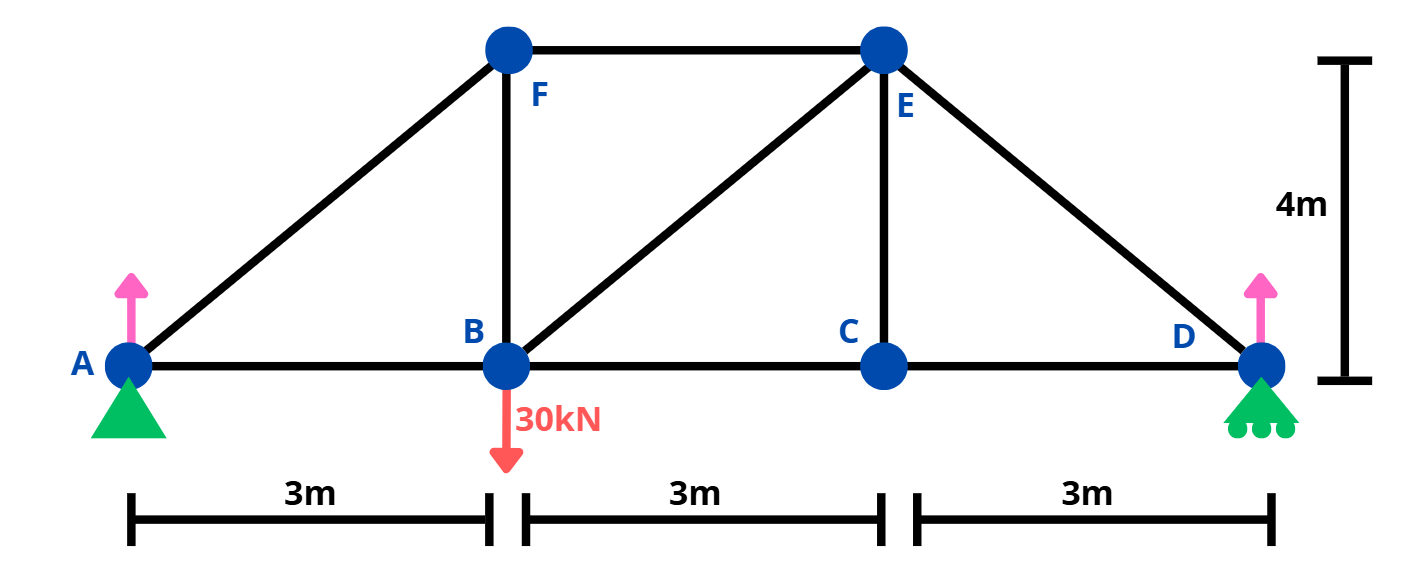

### Solução pelo FTOOL
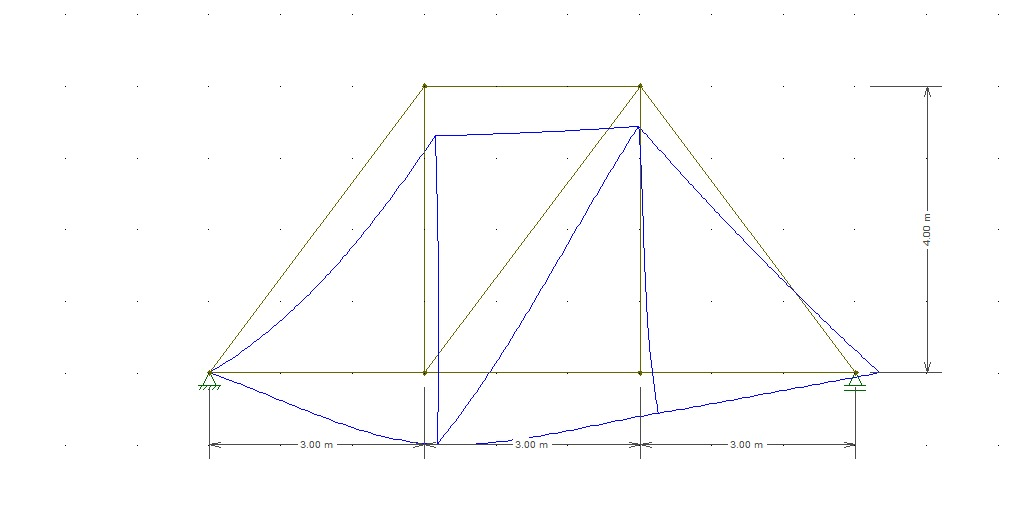


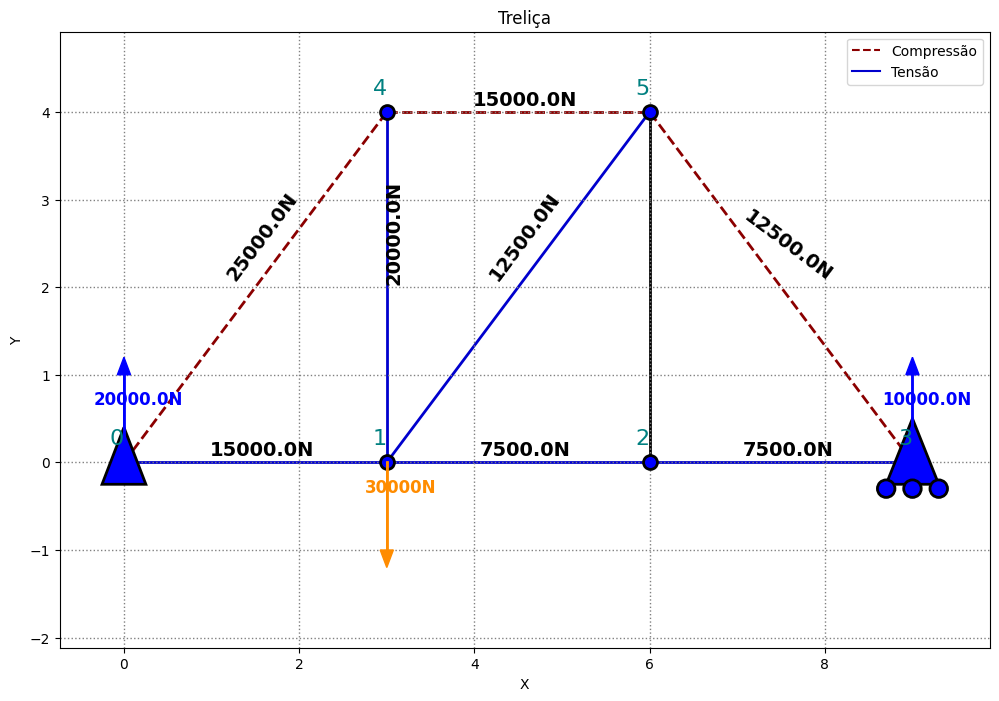




Deslocamentos das Vigas:
Viga 0: δ = 0.000002 m
Viga 1: δ = -0.000006 m
Viga 2: δ = 0.000001 m
Viga 3: δ = 0.000004 m
Viga 4: δ = 0.000003 m
Viga 5: δ = 0.000001 m
Viga 6: δ = 0.000000 m
Viga 7: δ = -0.000003 m
Viga 8: δ = -0.000002 m



<ipython-input-2-bd8a5e630d5d>:467: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


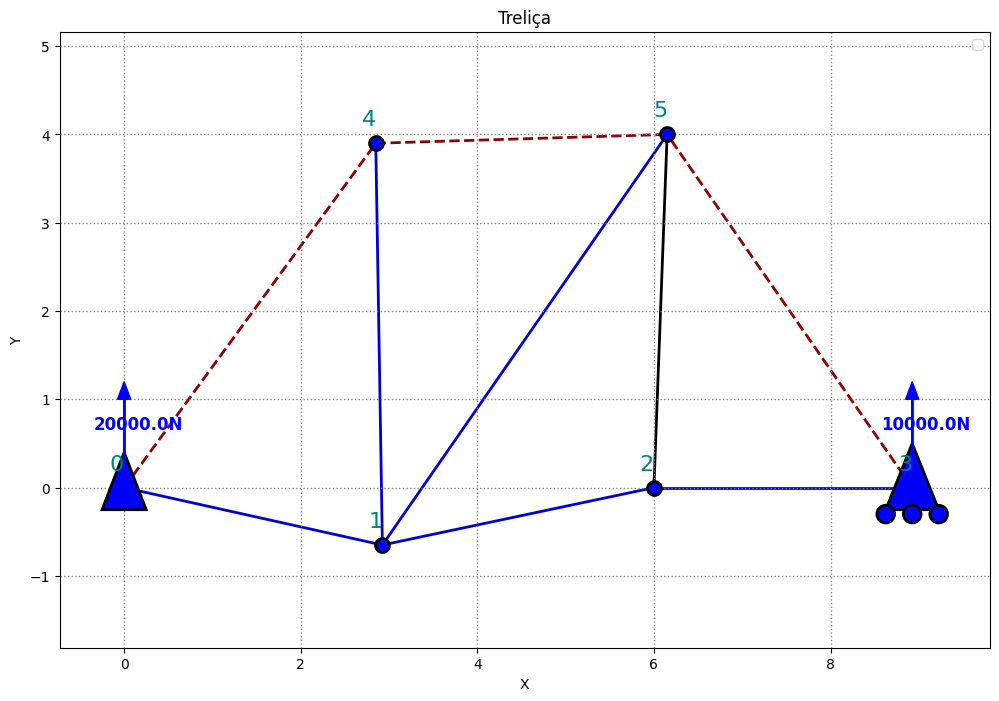

In [ ]:
A = 0.1  # Área da seção transversal da barra (m²)
E = 200e9  # Módulo de elasticidade (Pa)

# Definição dos nós
nodes = [
    Node(x=0, y=0, node_id=0, supports=[Support(rx=1, ry=1, rm=0)]),        # A
    Node(x=3, y=0, node_id=1, forces=[Force(magnitude=30000, angle=-90)]),  # B
    Node(x=6, y=0, node_id=2),                                              # C
    Node(x=9, y=0, node_id=3, supports=[Support(rx=0, ry=1, rm=0)]),        # D
    Node(x=3, y=4, node_id=4),                                              # E
    Node(x=6, y=4, node_id=5),                                              # F
]

# Definição das vigas
elements = [
    Element(nodes[0], nodes[1], element_id=0, A=A, E=E),   # AB
    Element(nodes[0], nodes[4], element_id=1, A=A, E=E),   # AF
    Element(nodes[1], nodes[2], element_id=2, A=A, E=E),   # BC
    Element(nodes[1], nodes[4], element_id=3, A=A, E=E),   # BF
    Element(nodes[1], nodes[5], element_id=4, A=A, E=E),   # BE
    Element(nodes[2], nodes[3], element_id=5, A=A, E=E),   # CD
    Element(nodes[2], nodes[5], element_id=6, A=A, E=E),   # CE
    Element(nodes[3], nodes[5], element_id=7, A=A, E=E),   # DE
    Element(nodes[4], nodes[5], element_id=8, A=A, E=E),   # FE
]

# Inicializa a treliça
truss = Truss(nodes=nodes, elements=elements)

# Resolve a treliça
system, solution = truss.analyze()

# Plot do resultados (Treliça Normal)
plot_truss(truss, plot_forces=True, plot_supports=True, plot_loads=True)

print("\n")

# Analisando a Treliça Deformada

print("\n====================")
deformed_truss = truss.analyse_deformed_truss(scaling=1e5)
print("====================\n")

plot_truss(deformed_truss, plot_forces=False, plot_supports=True, plot_loads=False, show=True)

# Exemplo 02

- $ A = 0.1 m^2 $
- $ E = 200*10^9  Pa$ ou $200 GPa$

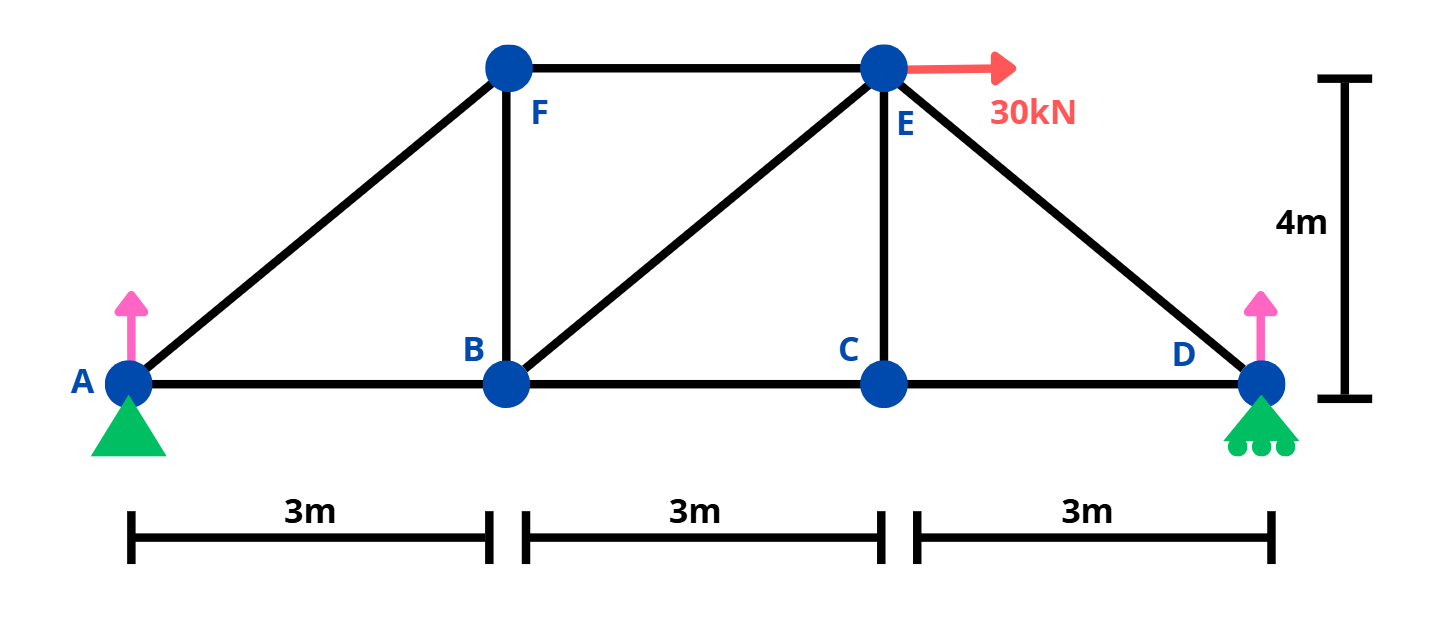

### Solução pelo FTOOL

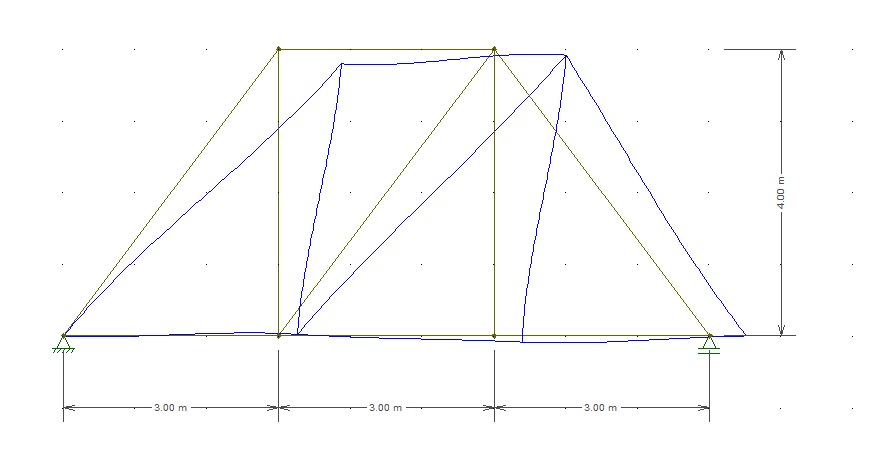

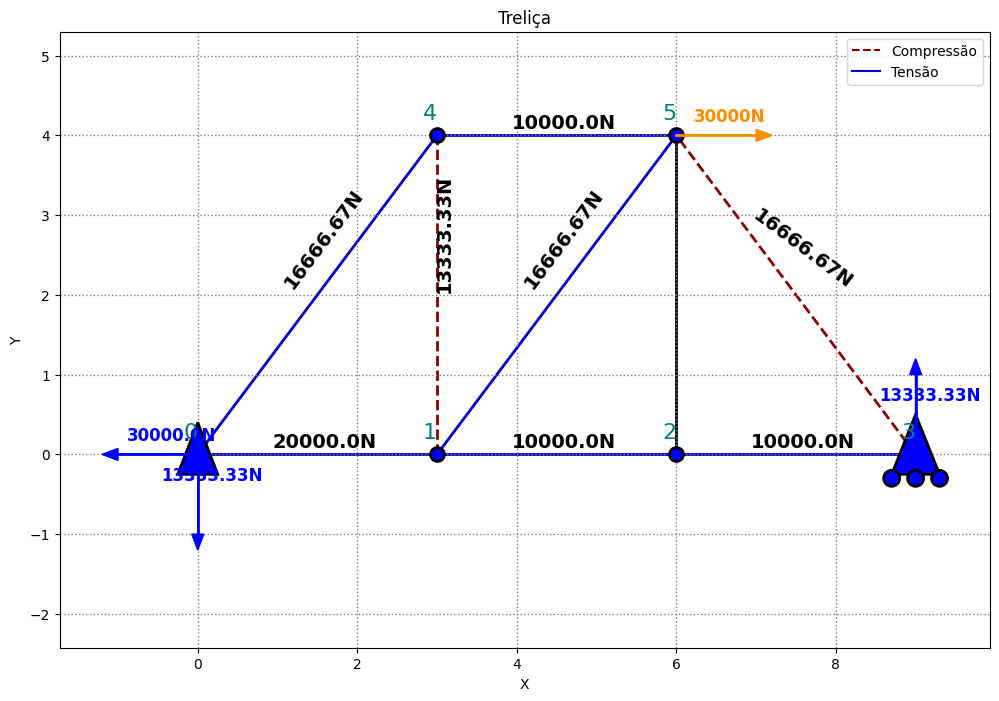




Deslocamentos das Vigas:
Viga 0: δ = 0.000003 m
Viga 1: δ = 0.000004 m
Viga 2: δ = 0.000002 m
Viga 3: δ = -0.000003 m
Viga 4: δ = 0.000004 m
Viga 5: δ = 0.000002 m
Viga 6: δ = 0.000000 m
Viga 7: δ = -0.000004 m
Viga 8: δ = 0.000002 m



<ipython-input-2-bd8a5e630d5d>:467: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


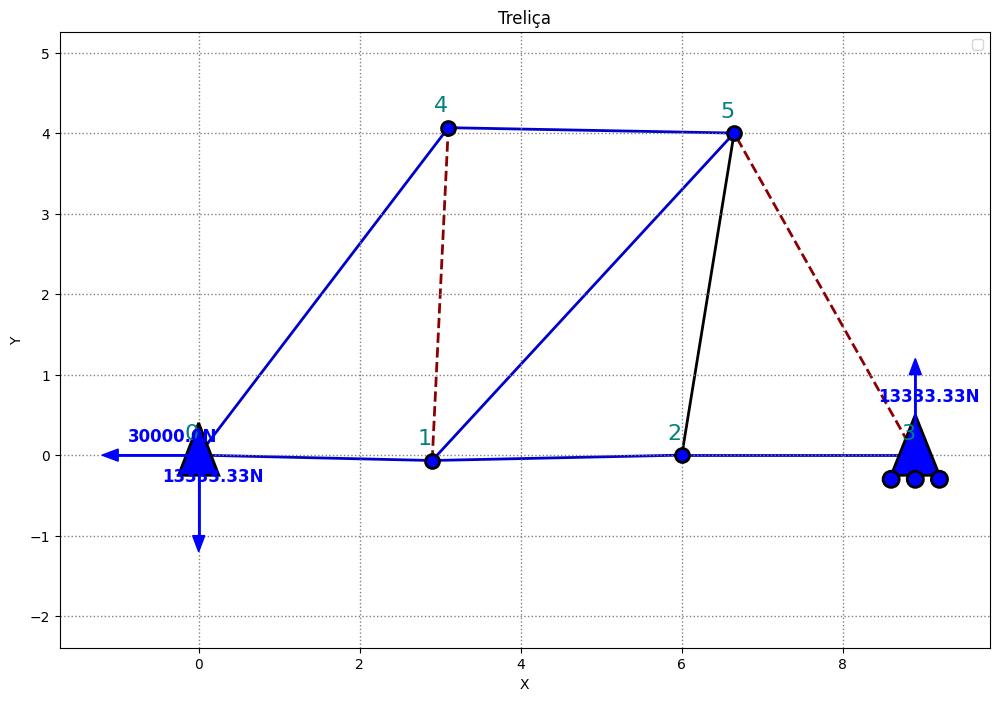

In [ ]:
A = 0.1  # Área da seção transversal da barra (m²)
E = 200e9  # Módulo de elasticidade (Pa)

# Definição dos nós
nodes = [
    Node(x=0, y=0, node_id=0, supports=[Support(rx=1, ry=1, rm=0)]),        # A
    Node(x=3, y=0, node_id=1),                                              # B
    Node(x=6, y=0, node_id=2),                                              # C
    Node(x=9, y=0, node_id=3, supports=[Support(rx=0, ry=1, rm=0)]),        # D
    Node(x=3, y=4, node_id=4),                                              # E
    Node(x=6, y=4, node_id=5, forces=[Force(magnitude=30000, angle=0)]),    # F
]

# Definição das vigas
elements = [
    Element(nodes[0], nodes[1], element_id=0, A=A, E=E),   # AB
    Element(nodes[0], nodes[4], element_id=1, A=A, E=E),   # AF
    Element(nodes[1], nodes[2], element_id=2, A=A, E=E),   # BC
    Element(nodes[1], nodes[4], element_id=3, A=A, E=E),   # BF
    Element(nodes[1], nodes[5], element_id=4, A=A, E=E),   # BE
    Element(nodes[2], nodes[3], element_id=5, A=A, E=E),   # CD
    Element(nodes[2], nodes[5], element_id=6, A=A, E=E),   # CE
    Element(nodes[3], nodes[5], element_id=7, A=A, E=E),   # DE
    Element(nodes[4], nodes[5], element_id=8, A=A, E=E),   # FE
]

# Inicializa a treliça
truss = Truss(nodes=nodes, elements=elements)

# Resolve a treliça
system, solution = truss.analyze()

# Plot do resultados (Treliça Normal)
plot_truss(truss, plot_forces=True, plot_supports=True, plot_loads=True)

print("\n")

# Analisando a Treliça Deformada

print("\n====================")
deformed_truss = truss.analyse_deformed_truss(scaling=1e5)
print("====================\n")

plot_truss(deformed_truss, plot_forces=False, plot_supports=True, plot_loads=False, show=True)